In [12]:
import os
import shutil
import numpy as np
import pandas as pd
import random

from tqdm import tqdm
from zipfile import ZipFile

import matplotlib.pyplot as plt

In [13]:
import tensorflow as tf

# image preprocessing
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img

# to build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.activations import softmax

# cost function / optimizer
from tensorflow.keras.optimizers import SGD, Adamax

In [14]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [15]:
def SEED_ALL(seed=1510):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
SEED_ALL()

In [16]:
MAIN_DIR = "kaggle/input/bach-breast-cancer-histology-images/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos"

In [17]:
BASE_DIR = "kaggle/working/bach-train"

# create two subfolders in base dir
TRAIN_DIR = os.path.join(BASE_DIR, "training")
VAL_DIR = os.path.join(BASE_DIR, "validation")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [18]:
bc_types = [file for file in os.listdir(MAIN_DIR) if os.path.isdir(os.path.join(MAIN_DIR, file))]
print("Types: ", bc_types)

# to encode labels
bc_dict = {'InSitu': 2, 'Benign': 1, 'Normal': 0, 'Invasive': 3}
print("Encode: ", bc_dict)

# to decode labels
dict_bc = {0: "Normal", 1: "Benign", 2: "InSitu", 3: "Invasive"}
print("Decode: ", dict_bc)

Types:  ['Benign', 'InSitu', 'Invasive', 'Normal']
Encode:  {'InSitu': 2, 'Benign': 1, 'Normal': 0, 'Invasive': 3}
Decode:  {0: 'Normal', 1: 'Benign', 2: 'InSitu', 3: 'Invasive'}


In [19]:
df = pd.read_csv("kaggle/working/bach_data.csv", index_col=0)
df.head()

,path,type
0,kaggle/input/bach-breast-cancer-histology-imag...,Benign
1,kaggle/input/bach-breast-cancer-histology-imag...,Benign
2,kaggle/input/bach-breast-cancer-histology-imag...,Benign
3,kaggle/input/bach-breast-cancer-histology-imag...,Benign
4,kaggle/input/bach-breast-cancer-histology-imag...,Benign


In [20]:
df["type"] = df["type"].map(bc_dict)
df.head()

,path,type
0,kaggle/input/bach-breast-cancer-histology-imag...,1
1,kaggle/input/bach-breast-cancer-histology-imag...,1
2,kaggle/input/bach-breast-cancer-histology-imag...,1
3,kaggle/input/bach-breast-cancer-histology-imag...,1
4,kaggle/input/bach-breast-cancer-histology-imag...,1


In [22]:
print(f"training size: {([len(os.path.join('kaggle/working/bach-train/training', bc)) for bc in os.listdir('kaggle/working/bach-train/training')])}")
print(f"Val size: {([len(os.path.join('kaggle/working/bach-train/validation', bc)) for bc in os.listdir('kaggle/working/bach-train/validation')])}")
print(f"Test size: {([len(os.path.join('kaggle/working/bach-train/test', bc)) for bc in os.listdir('kaggle/working/bach-train/test')])}")

training size: [41, 41, 43, 41]
Val size: [43, 43, 45, 43]
Test size: [37, 37, 39, 37]


In [23]:
IMG_SIZE = (int(1536*0.25), int(2048*0.25))
BATCH_SIZE = 8

def train_val_generators(train_dir, val_dir):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    train_gen = ImageDataGenerator(rescale=1/255.,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  zoom_range=0.2,)
    val_gen = ImageDataGenerator(rescale=1/255.)

    train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=IMG_SIZE)
    val_generator = val_gen.flow_from_directory(directory=val_dir,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              target_size=IMG_SIZE)
    return train_generator, val_generator

In [28]:
train_dir = 'kaggle/working/bach-train/training'
val_dir = 'kaggle/working/bach-train/validation'

In [29]:
def create_model():

    METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC'),
    ]
    
    model = Sequential([tf.keras.applications.Xception(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                                              include_top=False),
                               Conv2D(32, (3,3),activation="relu"),       
                               BatchNormalization(),
                               MaxPooling2D(2,2),
                               Dropout(0.3),
                               
                               Flatten(),
                               Dense(64, activation="relu"),
                               Dense(4, activation="softmax"),
                               ])
    model.compile(optimizer="adamax", loss="categorical_crossentropy", metrics=METRICS)

    return model

In [30]:
tf.keras.backend.clear_session()

train_generator, val_generator = train_val_generators(train_dir, val_dir)   # create image generators to feed images to the model
model = create_model()

print("\n[INFO] Ready to train. Training is starting!\n")

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)   # limitation to stop somewhere early

hist = model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=[callback])

Found 238 images belonging to 4 classes.
Found 81 images belonging to 4 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

[INFO] Ready to train. Training is starting!



c:\Users\pande\OneDrive\Desktop\code\AIML\Breast cancer\bcan\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - AUC: 0.6750 - accuracy: 0.4379 - loss: 1.6420 - precision: 0.4723 - recall: 0.3639

c:\Users\pande\OneDrive\Desktop\code\AIML\Breast cancer\bcan\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - AUC: 0.6759 - accuracy: 0.4394 - loss: 1.6374 - precision: 0.4743 - recall: 0.3649 - val_AUC: 0.5276 - val_accuracy: 0.2716 - val_loss: 2.3086 - val_precision: 0.2500 - val_recall: 0.1975
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - AUC: 0.7964 - accuracy: 0.5269 - loss: 1.1234 - precision: 0.6330 - recall: 0.4426 - val_AUC: 0.6525 - val_accuracy: 0.3210 - val_loss: 1.5289 - val_precision: 0.3636 - val_recall: 0.2469
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - AUC: 0.7923 - accuracy: 0.5925 - loss: 1.1779 - precision: 0.6453 - recall: 0.4851 - val_AUC: 0.7304 - val_accuracy: 0.4444 - val_loss: 1.2799 - val_precision: 0.5000 - val_recall: 0.3086
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - AUC: 0.8935 - accuracy: 0.7038 - loss: 0.8090 - precision: 0.7755 - recall: 0.6217 - val_AUC: 0.8150 - val_accuracy: 0.6049 - val_loss: 1.0806 - val_precision: 0.7018 - val_recall: 0.4938
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 108s 

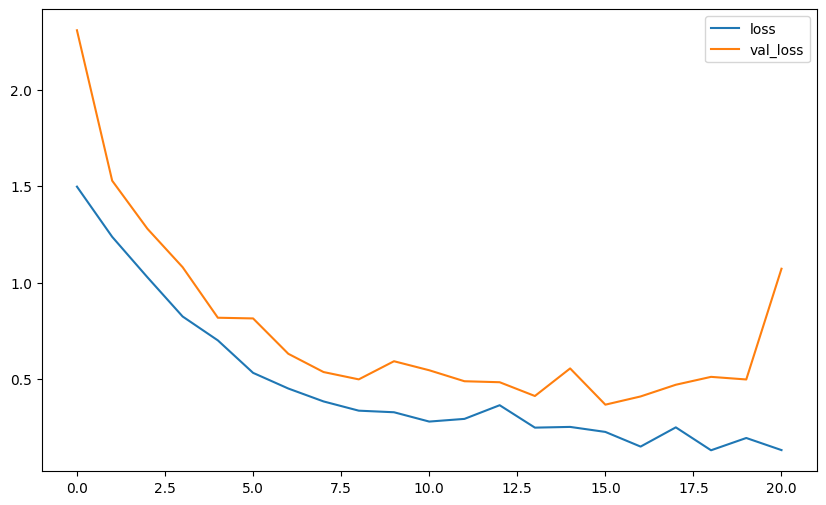

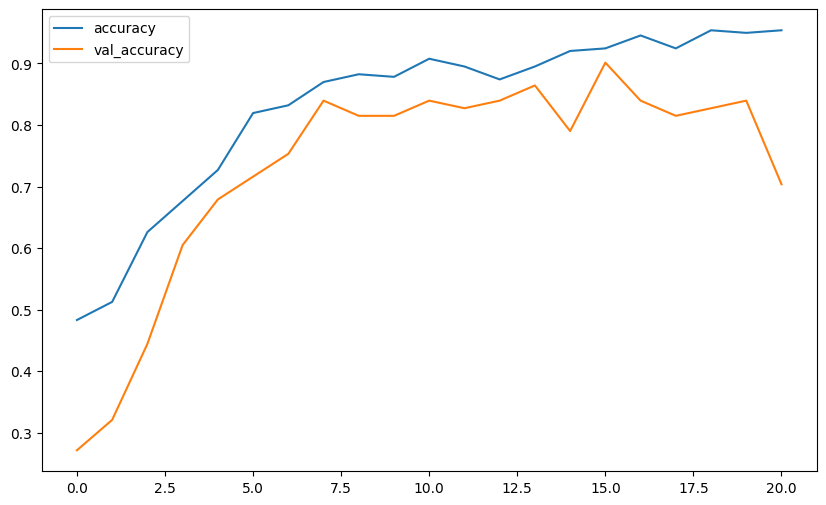

In [31]:
eps = range(len(hist.history["loss"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist.history["loss"])
plt.plot(eps, hist.history["val_loss"])
plt.legend(["loss", "val_loss"])

eps = range(len(hist.history["accuracy"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist.history["accuracy"])
plt.plot(eps, hist.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

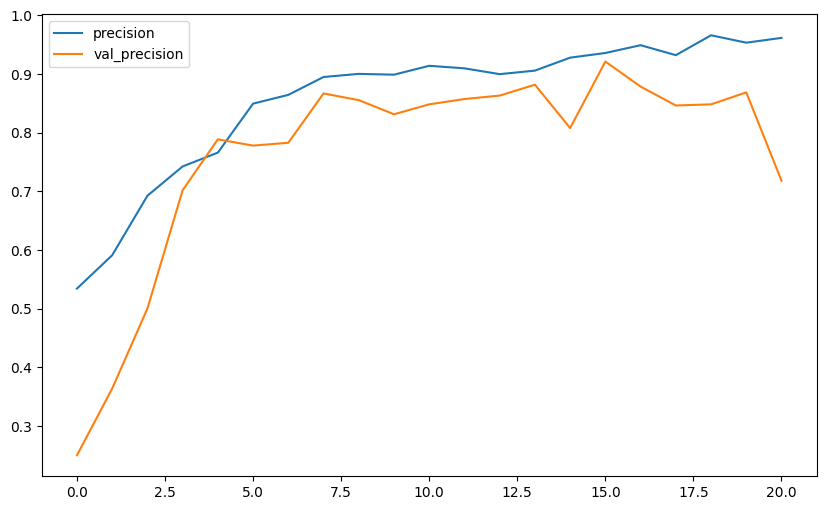

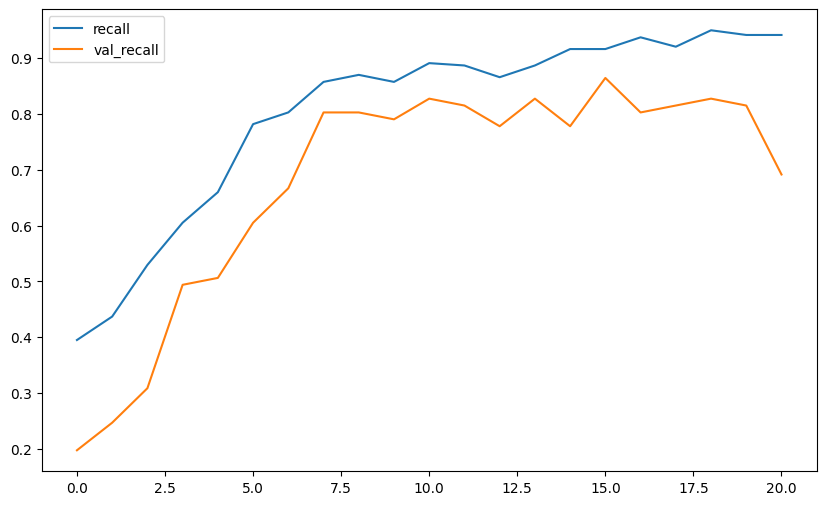

In [32]:
eps = range(len(hist.history["precision"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist.history["precision"])
plt.plot(eps, hist.history["val_precision"])
plt.legend(["precision", "val_precision"])

eps = range(len(hist.history["recall"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist.history["recall"])
plt.plot(eps, hist.history["val_recall"])
plt.legend(["recall", "val_recall"])

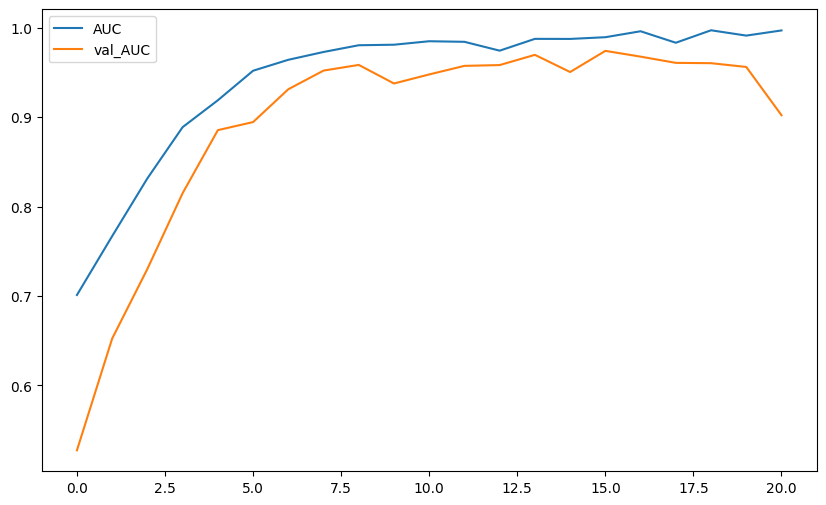

In [33]:
eps = range(len(hist.history["AUC"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist.history["AUC"])
plt.plot(eps, hist.history["val_AUC"])
plt.legend(["AUC", "val_AUC"])

In [34]:
test_gen = ImageDataGenerator(rescale=1/255.)
test_dir = os.path.join(BASE_DIR, "test")

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              target_size=IMG_SIZE)

Found 81 images belonging to 4 classes.


In [35]:
preds = model.predict(test_generator)

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 811ms/step


In [36]:
test_labels = []
pred_labels = []

for batch in range(0,int(len(test_generator))):
    batch_predicted = model.predict(test_generator[batch][0])
    for i in range(len(batch_predicted)):
        pred_labels.append(np.argmax(batch_predicted[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


In [37]:
for i in range(0,int(len(test_generator))):
    test_labels.extend(np.array(test_generator[i][1]))

In [38]:
test_labelss = []

for t in test_labels:
    test_labelss.append(np.argmax(t))

In [39]:
res = pd.DataFrame(data={"predicted": pred_labels, "ground_truth": test_labelss})
res.to_csv("/kaggle/working/predictions.csv")
res.head()

,predicted,ground_truth
0,1,1
1,1,2
2,0,0
3,1,2
4,1,3


In [40]:
model.evaluate(test_generator)

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 720ms/step - AUC: 0.8827 - accuracy: 0.7145 - loss: 1.1591 - precision: 0.7192 - recall: 0.7145


[1.0138553380966187,
 0.7407407164573669,
 0.7594936490058899,
 0.7407407164573669,
 0.9025300741195679]

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labelss, pred_labels)
cm

array([[11,  9,  0,  0],
       [ 0, 19,  1,  1],
       [ 0,  6, 14,  0],
       [ 2,  2,  0, 16]])

<Axes: >

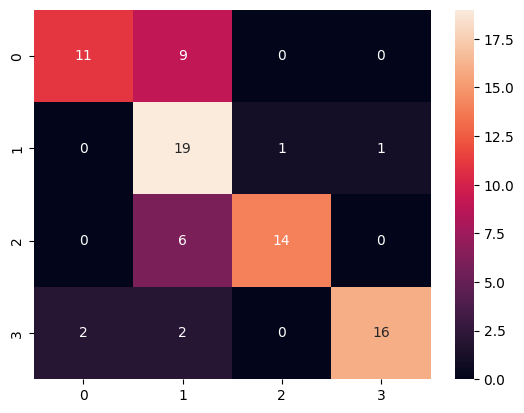

In [47]:
import seaborn as sns
sns.heatmap(cm, annot=True)

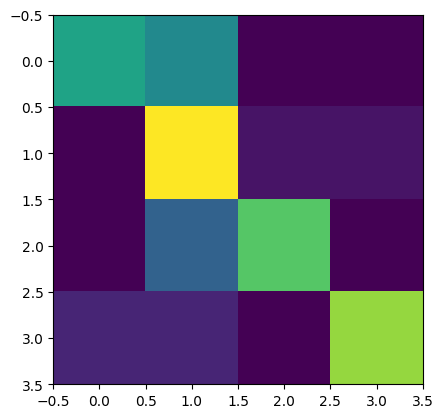

In [43]:
plt.imshow(cm)